In [9]:
from PlotUtil import apply_report_formatting
%matplotlib qt

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "xelatex",
    'font.family': 'sans-serif',
    'text.usetex': False,
    'pgf.rcfonts': False,
    'font.size': 10
})

## Plotting of the passes in the ECI frame

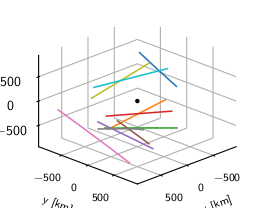

In [10]:
passes_df = pd.read_pickle('Telesat_0_7day.pkl')

N_passes = 10
passes_df = passes_df[0:N_passes]

fig = plt.figure(figsize=(3.2, 2.4))
ax = fig.add_subplot(111, projection='3d', proj_type = 'ortho')

for n in range(N_passes):
    pass_df = passes_df.iloc[n]
    r_ab = (pass_df.rr_a - pass_df.rr_b)/1000
    x, y, z = r_ab[:,0], r_ab[:,1], r_ab[:,2]
    line, = ax.plot(x, y, z, linewidth=1.125)

ax.scatter(0, 0, 0, s=20, c='#000000', marker='.', )
   
ax.set_xlabel('x [km]')
ax.set_ylabel('y [km]')
ax.set_zlabel('z [km]')
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.set_xlim(np.array([-1, 1]) * 900)
ax.set_ylim(np.array([-1, 1]) * 900)
ax.set_zlim(np.array([-1, 1]) * 900)
ax.view_init(30, 45)

plt.grid()
#plt.tight_layout()
plt.subplots_adjust(bottom=0.1)
apply_report_formatting()
plt.savefig('D:/git/thesis_report_ae/figures/passes_irf.pgf')

fig

In [11]:
import quaternion as qn

qq = [None] * len(passes_df)
ll = [None] * len(passes_df)

# Todo make this properly vectorized
for i, pass_df in passes_df.iterrows():
    rr_a = pass_df.rr_a
    rr_ab = pass_df.rr_b - pass_df.rr_a
        
    # Start by finding the rotation of the sc in the ECIF
    z_ecif = np.array([[0,0,1]])
    
    # ## Old options
    # # Be aware of the error in ww, vv1 is used twice!
    # vv1 = rr_a
    # vv2 = rr_ab
    # 
    # def find_quat_wrong(v1, v2):
    #     xyz = np.cross(v1, v2)
    #     x, y, z = xyz[:,0], xyz[:,1], xyz[:,2]
    #     w = np.sqrt(np.linalg.norm(v1, axis=1) ** 2 * np.linalg.norm(v1, axis=1)**2) + np.sum(v1*v2, axis=1)
    #     n = np.sqrt(x**2 + y**2 +  z**2 + w**2)
    #     return qn.as_quat_array(np.array([w, x, y, z]).T) / n
    # 
    # qq[i] = find_quat_wrong(vv1, vv2)
    #  
    
    def rotate_vectors(qq, vv):
        vvp = np.zeros(vv.shape)
        for j, q in enumerate(qq):
            q = q.normalized()
            vvp[j, :] = (q * np.quaternion(0, vv[j, 0], vv[j, 1], vv[j, 2]) * q.inverse()).vec

        return vvp

    # ll[i] = np.linalg.norm(vv2, axis=1)[:, np.newaxis] * rotate_vectors(qq[i], np.tile(z_ecif, (len(qq[i]), 1)))
    # #ll[i] = np.linalg.norm(vv2, axis=1)[:, np.newaxis] * qn.rotate_vectors(qq[i], [0,0,1])
    
    ## New method
    vv1 = rr_a
    vv2 = z_ecif
    
    def find_quat(v1, v2):
        # v1 - vector to rotate to
        # v2 - vector to rotate from
        xyz = np.cross(v1, v2)
        x, y, z = xyz[:,0], xyz[:,1], xyz[:,2]
        w = np.sqrt(np.linalg.norm(v1, axis=1) ** 2 * np.linalg.norm(v2, axis=1)**2) + np.sum(v1*v2, axis=1)
        n = np.sqrt(x**2 + y**2 +  z**2 + w**2)
        return qn.as_quat_array(np.array([w, x, y, z]).T) / n
    
    qq[i] = find_quat(vv1, vv2)
    ll[i] = rotate_vectors(qq[i], rr_ab)
    # def rotate_vectors(xx, yy, zz, ww, vv):
    #     # https://quaternion.readthedocs.io/en/latest/_autosummary/quaternion.html?highlight=rotate#quaternion.rotate_vectors
    #     mm = (xx**2 + yy**2 + zz**2 + ww**2)[:, np.newaxis]
    #     rr = np.array([xx, yy, zz]).T
    #     ss = np.atleast_2d(ww).T
    #     qq = qn.as_quat_array(np.array([xx, yy, zz, ww]).T) / mm
    #     return qq, vv + 2 * np.cross(rr, (ss * vv + np.cross(rr, vv))) / mm
    #         
    # # Old option (rotate z unit vector to point to data relay)
    # # rotate vectors is somewhat slow, see https://quaternion.readthedocs.io/en/latest/_autosummary/quaternion.html?highlight=rotate#quaternion.rotate_vectors
    # #ll[i] =  qn.rotate_vectors(qq[i], rr_ab)
    # qq[i], ll[i] = rotate_vectors(xx, yy, zz, ww, rr_ab)
            
passes_df['qq'] = qq
passes_df['ll'] = ll

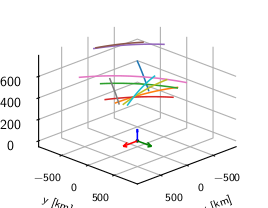

In [15]:
fig = plt.figure(figsize=(3.2, 2.4))
ax = fig.add_subplot(111, projection='3d', proj_type = 'ortho')

for i, pass_df in passes_df.head(N_passes).iterrows():
    ll = pass_df.ll/1000
    x, y, z = ll[:,0], ll[:,1], ll[:,2]
    line, = ax.plot(x, y, z, linewidth=1.125)

#ax.scatter(0, 0, 0, s=20, c='#000000', marker='.', )

ax.set_xlabel('x [km]')
ax.set_ylabel('y [km]')
ax.set_zlabel('z [km]')
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.set_xlim(np.array([-1, 1]) * 900)
ax.set_ylim(np.array([-1, 1]) * 900)
# # ax.set_zlim((-100, 100))
ax.view_init(30, 45)

per = 0.3
u = ax.get_xlim()[1]*per
v = ax.get_ylim()[1]*per
w = ax.get_zlim()[1]*per*0.5

# Plot coordinate system
ax.quiver(0,0,0, u,0,0, length=1, normalize=False, linewidth=1.125, color = 'r')
ax.quiver(0,0,0, 0,v,0, length=1, normalize=False, linewidth=1.125, color = 'g')
ax.quiver(0,0,0, 0,0,w, length=1, normalize=False, linewidth=1.125, color = 'b')
ax.scatter(0, 0, 0, s=10, c='#000000', marker='.', )

plt.grid()
plt.subplots_adjust(bottom=0.1)
apply_report_formatting()
plt.savefig('D:/git/thesis_report_ae/figures/passes_scf.pgf')

fig

## Range plot

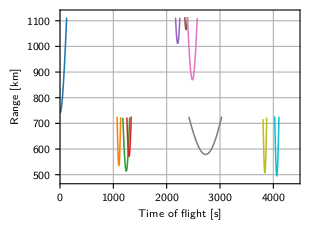

In [13]:
fig = plt.figure(figsize=(3.2, 2.4))

for i, pass_df in passes_df.head(N_passes).iterrows():
    ttof = pass_df.ttof
    d = np.linalg.norm(pass_df.ll, axis=1)/1000
    line, = plt.plot(ttof, d, linewidth=1.125)
 
plt.xlabel('Time of flight [s]')
plt.ylabel('Range [km]')
plt.xlim((0, 4500))   

plt.grid()
apply_report_formatting()
plt.tight_layout()
plt.savefig('D:/git/thesis_report_ae/figures/range.pgf')

fig


## Sky plot

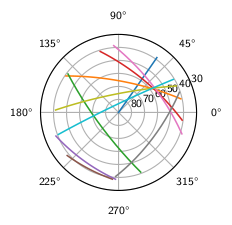

In [14]:
fig = plt.figure(figsize=(2.4, 2.4))

def xyz_to_shperical(xyz):
    xy = xyz[:,0]**2 + xyz[:,1]**2
    r = np.sqrt(xy + xyz[:,2]**2)
    theta = np.arctan2(np.sqrt(xy), xyz[:,2]) # for elevation angle defined from Z-axis down
    phi = np.arctan2(xyz[:,1], xyz[:,0])
    return r, theta, phi

for i, pass_df in passes_df.head(N_passes).iterrows():
    ll = pass_df.ll/1000
    r, theta, phi = xyz_to_shperical(ll)
    line, = plt.polar(phi, theta * 180 / np.pi, linewidth=1.125)

plt.yticks(ticks=plt.yticks()[0], labels=["%d" % v for v in 90 - np.array(plt.yticks()[0])])
#plt.grid()
apply_report_formatting()
plt.tight_layout()
# plt.subplots_adjust(bottom=0.1)
plt.savefig('D:/git/thesis_report_ae/figures/skyplot.pgf')

fig